In [2]:
# Connect to Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

# Define the file path in Google Drive
file_path = '/content/drive/MyDrive/heart_2022_no_nans.csv'

# Install the Pandas library if not installed
!pip install pandas

# Import Pandas
import pandas as pd

# Read the CSV file
df = pd.read_csv(file_path)

# Explore the data
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 4.0               0.0   
1  Alabama    Male     Very good                 0.0               0.0   
2  Alabama    Male     Very good                 0.0               0.0   
3  Alabama  Female          Fair                 5.0               0.0   
4  Alabama  Female          Good                 3.0              15.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                Yes   
1  Within past year (anytime less than 12 months ...                Yes   
2  Within past year (anytime less than 12 months ...                 No   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ..

In [3]:
# Import necessary libraries for modeling
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
import numpy as np

In [4]:
# Read the data again
file_path = '/content/drive/MyDrive/heart_2022_no_nans.csv'
df = pd.read_csv(file_path)

# Replace categorical values with numerical ones
replacement_dict = {'Yes': 1, 'No': 0}
df['HadHeartAttack'] = df['HadHeartAttack'].replace(replacement_dict)
df['HadAngina'] = df['HadAngina'].replace(replacement_dict)

# Create a new target column
df['HeartDisease'] = df['HadHeartAttack'] | df['HadAngina']

# Select specific columns
columns_to_keep = ['HeartDisease', 'BMI', 'SmokerStatus', 'AlcoholDrinkers', 'HadStroke', 'PhysicalHealthDays',
                    'MentalHealthDays', 'DifficultyWalking', 'Sex', 'AgeCategory', 'HadDiabetes', 'PhysicalActivities',
                    'GeneralHealth', 'SleepHours', 'HadKidneyDisease']

df_subset_old = df[columns_to_keep]

# Display the target value counts
print(df_subset_old["HeartDisease"].value_counts())

# Filter values based on a specific column
filtered_df_0 = df_subset_old[df_subset_old['HeartDisease'] == 0]
filtered_df_1 = df_subset_old[df_subset_old['HeartDisease'] == 1]

0    224406
1     21616
Name: HeartDisease, dtype: int64


In [5]:
# Limit the size of the majority class for balance
size = 180000
if len(filtered_df_0) > size:
    filtered_df_0 = filtered_df_0.head(size)

# Concatenate the filtered dataframes
frames = [filtered_df_0, filtered_df_1]
df_subset = pd.concat(frames)

# Display target value counts after filtering
print(filtered_df_0["HeartDisease"].value_counts())
print(filtered_df_1["HeartDisease"].value_counts())
print(df_subset["HeartDisease"].value_counts())

# Use label encoding for categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['HeartDisease', 'SmokerStatus', 'AlcoholDrinkers', 'HadStroke', 'DifficultyWalking', 'Sex', 'GeneralHealth', 'AgeCategory', 'HadDiabetes', 'PhysicalActivities', 'HadKidneyDisease']

for column in categorical_columns:
    df_subset[column] = label_encoder.fit_transform(df_subset[column])

# Display the modified dataframe
print(df_subset.head())

# Split the data into training and testing sets
X = df_subset.drop('HeartDisease', axis=1)
y = df_subset['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

0    180000
Name: HeartDisease, dtype: int64
1    21616
Name: HeartDisease, dtype: int64
0    180000
1     21616
Name: HeartDisease, dtype: int64
   HeartDisease    BMI  SmokerStatus  AlcoholDrinkers  HadStroke  \
0             0  27.99             2                0          0   
1             0  30.13             2                0          0   
2             0  31.66             2                1          0   
3             0  31.32             3                0          0   
4             0  33.07             3                0          0   

   PhysicalHealthDays  MentalHealthDays  DifficultyWalking  Sex  AgeCategory  \
0                 4.0               0.0                  0    0            9   
1                 0.0               0.0                  0    1           10   
2                 0.0               0.0                  1    1           11   
3                 5.0               0.0                  1    0           12   
4                 3.0              15.0      

In [6]:
# Create the model
model = Sequential()

# 1. Conv1D Layer
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1), name='conv1d_1'))
model.add(Dropout(0.2, name='dropout_1'))

# 2. Conv1D Layer
model.add(Conv1D(128, 3, activation='relu', name='conv1d_2'))
model.add(Dropout(0.2, name='dropout_3'))

# 3. Conv1D Layer
model.add(Conv1D(128, 3, activation='relu', name='conv1d_4'))
model.add(MaxPooling1D(name='max_pooling1d_1'))

model.add(Conv1D(64, 3, activation='relu', name='conv1d_5'))
model.add(MaxPooling1D(name='max_pooling1d_2'))

# Fully Connected Layer
model.add(Dense(64, activation='relu', name='dense_1'))
model.add(Dense(128, activation='relu', name='dense_3'))
model.add(Dense(64, activation='relu', name='dense_5'))

# Output Layer
model.add(Dense(1, activation='sigmoid', name='dense_4'))

# Compile the model
opt = Adamax(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
4033/4033 [==============================] - 82s 20ms/step - loss: 0.2920 - accuracy: 0.8926 - val_loss: 0.2773 - val_accuracy: 0.8937
Epoch 2/10
4033/4033 [==============================] - 59s 15ms/step - loss: 0.2790 - accuracy: 0.8927 - val_loss: 0.2747 - val_accuracy: 0.8937
Epoch 3/10
4033/4033 [==============================] - 60s 15ms/step - loss: 0.2765 - accuracy: 0.8929 - val_loss: 0.2710 - val_accuracy: 0.8940
Epoch 4/10
4033/4033 [==============================] - 60s 15ms/step - loss: 0.2746 - accuracy: 0.8931 - val_loss: 0.2688 - val_accuracy: 0.8956
Epoch 5/10
4033/4033 [==============================] - 58s 14ms/step - loss: 0.2728 - accuracy: 0.8932 - val_loss: 0.2687 - val_accuracy: 0.8945
Epoch 6/10
4033/4033 [==============================] - 58s 14ms/step - loss: 0.2709 - accuracy: 0.8936 - val_loss: 0.2704 - val_accuracy: 0.8945
Epoch 7/10
4033/4033 [==============================] - 58s 14ms/step - loss: 0.2703 - accuracy: 0.8941 - val_loss: 0.2680 -

In [8]:

# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

1261/1261 [==============================] - 6s 5ms/step - loss: 0.2660 - accuracy: 0.8949
Test Loss: 0.2660430073738098
Test Accuracy: 0.8949260711669922


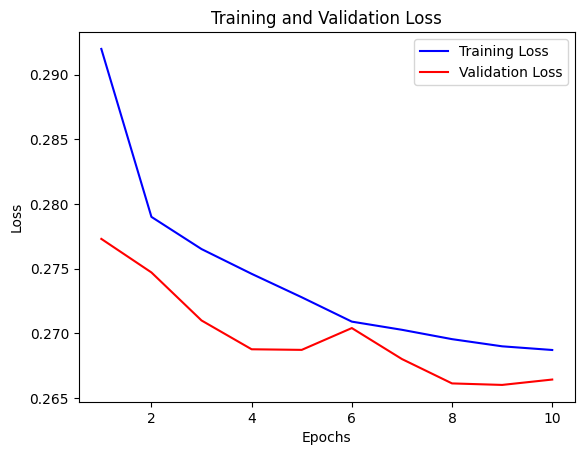

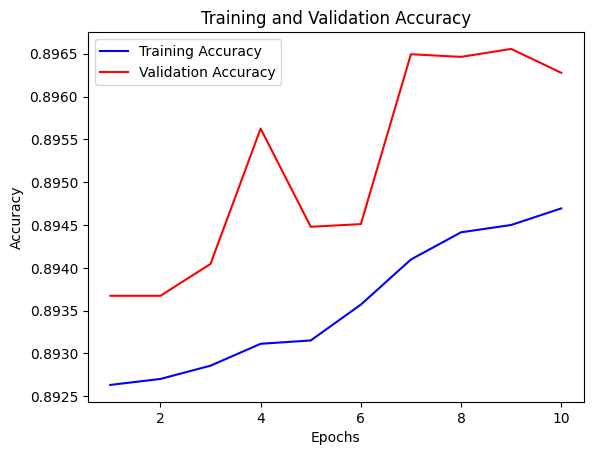

In [9]:

# Plot the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the Loss graph
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the Accuracy graph
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:

# Save the model
model.save('model_kaydiSon2.h5')

# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('model_kaydiSon2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
